In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import datetime
from queue import Queue
from collections import deque
from scipy.stats import norm
from itertools import accumulate

from utils import parse_date,determine_R0,return_polyfit,decay_to_max,unwrap_projections
from generators import advanced_projector,infection_projector

%matplotlib inline
plt.style.use('fivethirtyeight')

# Plotting functions

In [3]:
def plot_totals(cases,deaths=None):
    epochs = range(1,len(cases)+1)
    _, ax = plt.subplots()
    ax.plot(epochs,cases,'g',label="Confirmed Cases")
    if deaths:
        ax.plot(epochs,deaths,'m',label="Deaths")
    ax.set_title('Covid19')
    ax.set_xlabel('Days')
    ax.set_ylabel('Cases')
    ax.legend()
    plt.show()
    # plt.savefig('assets/Covid19',bbox_inches='tight')
    # plt.close()
    
def detailed_plot(values,labels):
    colors = ['b','g','r','c','m','y','lightblue','lightgreen','gray','teal']
    for i,x in enumerate(values):
        epochs = range(1,len(x)+1)
        plt.plot(epochs,x,colors[i],label=f"{labels[i]}")
        plt.title('Covid19')
        plt.xlabel('Days')
        plt.ylabel('Cases')
        plt.legend()
    plt.show()

# Data paths

Data gathered by download_datasets.sh

In [4]:
general_path = 'novel-corona-virus-2019-dataset'
korea_path = 'coronavirusdataset'
USA_path = 'covid19-in-usa'
Italy_path = 'covid19-in-italy'
coronavirusapi_States_path = 'states.csv'
coronavirusapi_USA_path = 'time_series.csv'
covidtracking_States_path = 'states_daily.csv'
covidtracking_USA_path = 'us_daily.csv'

In [5]:
korea_timeline = os.path.join(korea_path,'Time.csv')
general_timeline = os.path.join(general_path,'time_series_covid_19_confirmed.csv')
USA_1 = os.path.join(USA_path,'us_covid19_daily.csv')
USA_2 = os.path.join(USA_path,'us_states_covid19_daily.csv')
italy_file = os.path.join(Italy_path,'covid19_italy_region.csv')
italy_file2 = os.path.join(Italy_path,'covid19_italy_province.csv')

In [6]:
korea_df = pd.read_csv(korea_timeline)
general_df = pd.read_csv(general_timeline)
USA_1df = pd.read_csv(USA_1)
USA_2df = pd.read_csv(USA_2)
italy_df = pd.read_csv(italy_file)
italy_df2 = pd.read_csv(italy_file2)
coronavirusapi_States_df = pd.read_csv(coronavirusapi_States_path)
coronavirusapi_USA_df = pd.read_csv(coronavirusapi_USA_path)
covidtracking_States_df = pd.read_csv(covidtracking_States_path)
covidtracking_USA_df = pd.read_csv(covidtracking_USA_path)
USA_testing_df = pd.read_csv(coronavirusapi_USA_path)

In [7]:
Italy = general_df[general_df['Country/Region'] == 'Italy']
US = general_df[general_df['Country/Region'] == 'US']

In [8]:
covidtracking_USA_df.tail()

,date,states,positive,negative,posNeg,pending,hospitalized,death,total
15,20200319,56,11723,89119,100842,3025,NaN,160.0,103867
16,20200320,56,17038,118147,135185,3336,NaN,219.0,138521
17,20200321,56,23203,155909,179112,3477,1964.0,322.0,182589
18,20200322,56,31888,193463,225351,2842,2554.0,398.0,228216
19,20200323,56,42164,237321,279485,14571,2664.0,471.0,294056


# Extend testing data

In [9]:
unique_dates = USA_testing_df['date'].unique()
tests_preformed = []
tests_positive = []
for date in unique_dates:
    rows = USA_testing_df[USA_testing_df['date'] == date]
    tests_preformed.append(rows['tested'].values[-1])
    tests_positive.append(rows['positive'].values[-1])
data_dict = {'dates':unique_dates,'tested':tests_preformed,'positive': tests_positive}
df_us_tests = pd.DataFrame.from_dict(data_dict)
df_us_tests['ratio'] = df_us_tests['positive'] / df_us_tests['tested']
print(df_us_tests['ratio'].mean())

0.14289994297181863


In [10]:
X1 = 5
Y1 = np.gradient(df_us_tests['tested'].values)[X1]
X2 = 13
Y2 = np.gradient(df_us_tests['tested'].values)[X2]
points = [(X1,Y1),(X2,Y2)]
degree = 3

print(f'X1,Y1 {X1,Y1}')
print(f'X2,Y2 {X2,Y2}')
test_base,A_factor = determine_R0(points)

X1,Y1 (5, 4751.0)
X2,Y2 (13, 37256.0)


last_point 134959.42569438403 new_point 142479.71284719202


/Users/morgan/Code/Covid19/utils.py:32: RankWarning: The fit may be poorly conditioned
  coefs = poly.polyfit(x, y, degree)


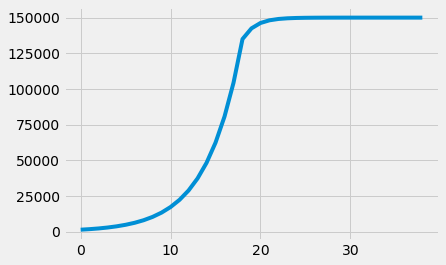

In [11]:
line,coefs = return_polyfit(np.array([X1,X2]),np.array([Y1,Y2]),degree)
max_daily_tests = 150*1e+3
Ys = np.power(test_base,np.arange(19))*A_factor
end_ys = decay_to_max(max_daily_tests,Ys[-1],20)

projected_tests = np.concatenate([Ys,end_ys])
plt.plot(projected_tests)

# USA projections

## Initial assumptions

In [12]:
population = 5
R0 = 2.3
asymptomatic_period = 5
hospitalization_rate = 0.05
inflection_point = 9 # of cycles since to Jan 24 to March 16
R0_reduction = 0.9
base_R0 = 0.90
hospital_days = 14
daily_traveler_cases = 50

adv_params = {
        'population':population,
        'R0':R0,
        'asymptomatic_period':asymptomatic_period,
        'hospitalization_rate':hospitalization_rate,
        'inflection_point':inflection_point,
        'R0_reduction':R0_reduction,
        'base_R0':base_R0,
        'hospital_days': hospital_days,
        'tests':projected_tests,
        'pos_rate':0.14,
        'traveler_cases':daily_traveler_cases,
        'print':False
         }

# Generate predictions

In [13]:
advGenerator = advanced_projector(adv_params)
advcurve_data = []
for _ in range(16):
    advcurve_data.append(next(advGenerator))

In [23]:
projection_data = unwrap_projections(advcurve_data)

9


In [14]:
US_positive = covidtracking_USA_df['positive']
US_negative = covidtracking_USA_df['negative']
US_tests = covidtracking_USA_df['posNeg']
US_hospitalized = covidtracking_USA_df['hospitalized']
US_deaths = covidtracking_USA_df['death']

In [15]:
US_cases = US.iloc[:,4:]
US_totals = US_cases.sum(axis=0).values

In [16]:
US_actual_start = datetime.datetime(2020,1,20)
print(f'Duration since first case {datetime.datetime.now() - US_actual_start}')

Duration since first case 63 days, 16:47:17.332307


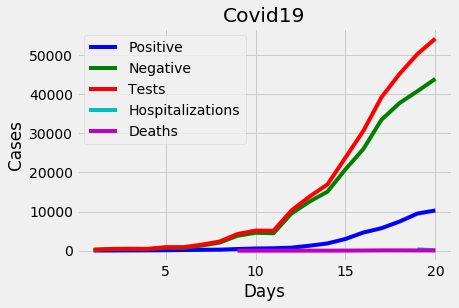

In [17]:
values = [np.gradient(US_positive),np.gradient(US_negative),np.gradient(US_tests),np.gradient(US_hospitalized),np.gradient(US_deaths)]
labels = ['Positive','Negative','Tests','Hospitalizations','Deaths']
detailed_plot(values,labels)

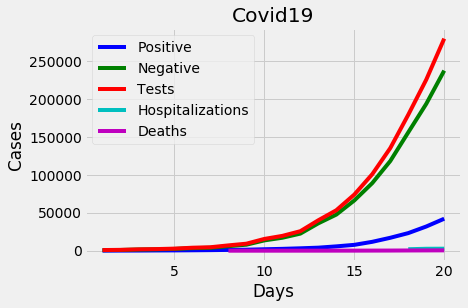

In [18]:
values = [US_positive,US_negative,US_tests,US_hospitalized,US_deaths]
labels = ['Positive','Negative','Tests','Hospitalizations','Deaths']
detailed_plot(values,labels)

# Italy

In [19]:
italy_cases = Italy.iloc[:,4:]
italy_totals = italy_cases.values[0]

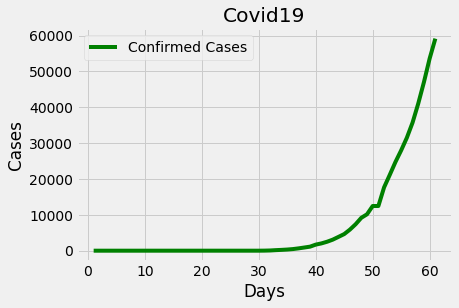

In [20]:
plot_totals(italy_totals)

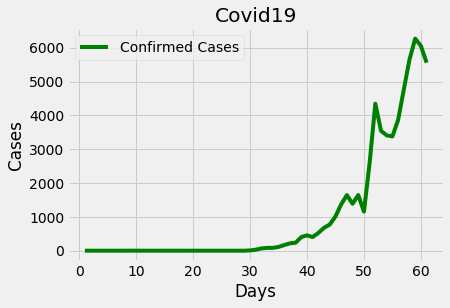

In [21]:
plot_totals(np.gradient(italy_totals))

In [22]:
peak_italy_index = np.argmax(np.gradient(italy_totals))
print(f'Peak index {peak_italy_index}')
print(f'Confirmed cases {italy_totals[peak_italy_index]}')

italy_first_case_index = np.min(np.nonzero(italy_totals))
italy_start_date = parse_date(Italy.columns[4+italy_first_case_index])
italy_peak_date = parse_date(Italy.columns[4+peak_italy_index])
print(f'Date of first case {italy_start_date}')
print(f'Date of peak {italy_peak_date}')

print(f'Duration until peak {italy_peak_date - italy_start_date}')
print(f'Duration since first case {datetime.datetime.now() - italy_start_date}')

Peak index 58
Confirmed cases 47021
Date of first case 2020-01-31 00:00:00
Date of peak 2020-03-20 00:00:00
Duration until peak 49 days, 0:00:00
Duration since first case 52 days, 16:47:18.146142
